In [284]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import copy
import yfinance as yf
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [285]:
"""Testing for a GPU"""

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))
x = tf.random.uniform([3, 3])

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


Data Preperation

In [286]:
"""Loading s&p 100 tickers"""



sample_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
interval = '1h'
training_start = "2024-03-03"
training_end = "2025-10-10"
testing_end = "2026-01-01"
data = yf.download(sample_tickers, start=training_start, end=training_end, interval=interval)

close = data['Close']
volume = data['Volume']


[*********************100%***********************]  5 of 5 completed


In [287]:
close.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Datetime,,,,,
2024-03-04 14:30:00+00:00,174.169998,179.610001,133.084396,414.470001,84.828003
2024-03-04 15:30:00+00:00,174.815002,178.979996,132.464996,415.845001,85.216164
2024-03-04 16:30:00+00:00,174.626999,178.309998,132.803207,416.359985,86.033005
2024-03-04 17:30:00+00:00,173.904999,178.115005,132.565002,415.609985,86.612999
2024-03-04 18:30:00+00:00,174.350006,178.207794,132.949997,414.880005,87.143997


In [288]:
close.tail()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Datetime,,,,,
2025-10-09 15:30:00+00:00,253.845001,224.162994,241.039993,519.640015,193.850006
2025-10-09 16:30:00+00:00,253.457596,223.860001,240.869995,518.820007,192.610001
2025-10-09 17:30:00+00:00,253.559998,226.270004,240.630096,520.229980,192.875000
2025-10-09 18:30:00+00:00,253.899994,227.044998,240.899994,520.400024,193.119995
2025-10-09 19:30:00+00:00,253.979996,227.619995,241.279999,522.070007,192.294998


In [289]:
close_np = data['Close'].to_numpy()
volume_np = data['Volume'].to_numpy()

In [290]:
from technical_indicators import AddTechnicalIndicators

indicator_class = AddTechnicalIndicators(close, sample_tickers)
data = indicator_class.add_sma()
data = indicator_class.add_ema()
data = indicator_class.add_rsi()

data_frame = data 
data = data.to_numpy()




/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [291]:
print(data[0])

[174.16999817 179.61000061 133.08439636 414.47000122  84.82800293
          nan          nan          nan          nan          nan
 174.16999817 414.47000122 133.08439636 179.61000061  84.82800293
          nan          nan          nan          nan          nan]


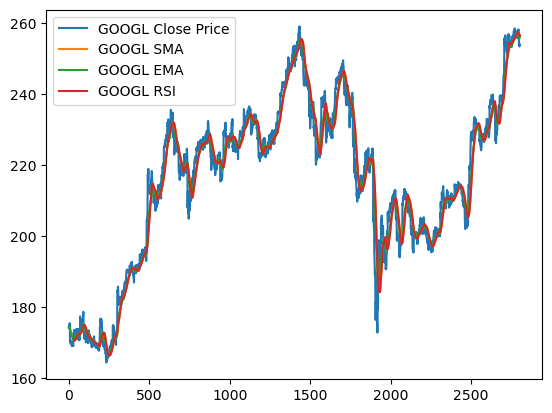

In [292]:
googl = data[:, 0]
googl_sma = data[:, 5]
googl_ema = data[:, 10]
googl_rsi = data[:, 5]

plt.plot(googl, label='GOOGL Close Price')
plt.plot(googl_sma, label='GOOGL SMA')
plt.plot(googl_ema, label='GOOGL EMA')
plt.plot(googl_rsi, label='GOOGL RSI')
plt.legend()
plt.show()

In [293]:
print(data.shape)

(2805, 20)


In [294]:
from numpy.lib.stride_tricks import sliding_window_view

def add_look_back(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i])
    return numpy.array(X), numpy.array(y)

In [295]:
lookback = 10
x, y = add_look_back(data, look_back=lookback)
print(x.shape)
print(y.shape)
print(close.shape)


(2795, 10, 20)
(2795, 20)
(2805, 20)


In [296]:
print(data_frame.to_numpy())
print(data_frame.to_numpy().shape)

[[174.16999817 179.61000061 133.08439636 ...          nan          nan
           nan]
 [174.81500244 178.97999573 132.46499634 ...          nan          nan
           nan]
 [174.6269989  178.30999756 132.8032074  ...          nan          nan
           nan]
 ...
 [253.55999756 226.27000427 240.63009644 ...  38.61456382  59.26152698
   57.628837  ]
 [253.8999939  227.04499817 240.8999939  ...  40.37193454  65.7963628
   61.39092966]
 [253.97999573 227.61999512 241.27999878 ...  40.72347392  67.25496302
   59.0561177 ]]
(2805, 20)


In [297]:

a = np.array([ [0, 10, 20, 30], [2, 9, 19, 40],[3, 8, 19, 21] ])

assert np.array_equal(np.min(a, axis=0), np.array([0, 8, 19, 21])), f'not equal {np.min(a)},  {np.array([0, 9, 19, 30])}'

class MinMaxScaling:
    def __init__(self, data):

        self.min =np.max(np.array([np.min(data, axis=0), np.ones(data.shape[1])/100_0000 ]),axis=0)
        self.max = np.max(data, axis = 0)
        print(self.min,self.max)
    def transform(self, x):

        return (x - self.min)/(self.max - self.min)
    
    def inverse(self, x):
        return x*(self.max - self.min) + self.min

class RollingZScoreNorm:
    def __init__(self, data, look_back=30):
        self.data = data
    
    
    def get_rolling_z(self, window=30):
        """Add Rolling Z-Score to the data."""
        """Final Ouput must then me computed as """

        data = self.data
        data_np = data.to_numpy()
        normalized_data = copy.deepcopy(data)

        for col in self.data.columns:
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            normalized_data[col] = (data[col] - rolling_mean) / rolling_std

        # Starts at 
        
        normalized_data = []

        print(data_np.shape)
        print(window)

        for col in range(data_np.shape[1]):
            print(col)
            column = []
            print(window, data_np.shape[0])
            for i in range(window, data_np.shape[0]):
                print(i)
                data_window = data_np[i - window:i][col]
                print(i-window, i, col, data_window)
                mean = np.mean(data_window)
                variance = np.var(data_window)
                column.append((data_window[-1]-mean )/ variance)

                assert False

            normalized_data.append(column)

        assert np.array(normalized_data).shape[1:] == data_np.shape[1:], f'Mishmach normed:{np.array(normalized_data).shape[1:]}  data:{data_np.shape[1:]} full shapes: normed:{np.array(normalized_data).shape}  data:{data_np.shape} '

                
        
        return np.array(normalized_data)
    
    def inverse_transform(self, normalized_output, window=30):
        """normalized_output must be a numpy array"""
        """Inverse transform the normalized data back to original scale."""
        data = self.data
        inv_data = normalized_output.copy()


        for i, col in  enumerate(self.data.columns):
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            inv_data[i] = (normalized_output[i] * rolling_std) + rolling_mean
        return inv_data
    


In [298]:
data = data_frame.to_numpy()[59:]

In [299]:
# norm_class = RollingZScoreNorm(data_frame)
# norm_data = norm_class.get_rolling_z(wi)
print(data.shape)
# min_max_scaling = MinMaxScaling(data)

from sklearn.preprocessing import StandardScaler



min_max_scaling = StandardScaler()

norm_data
min_max_scaling.fit(data)
norm_data = min_max_scaling.transform(data)


(2746, 20)


In [300]:
# norm_data.to_numpy()[29]

In [301]:

x, y = add_look_back(norm_data, look_back=lookback)

X = x
Y = y[:, :5]

In [302]:
print(X.shape, Y.shape)

(2736, 10, 20) (2736, 5)


Basic Model

In [303]:
from keras import layers, Sequential

In [304]:
print(lookback, X.shape[2])

10 20


In [305]:
model = keras.Sequential()

model.add(layers.Dense(512, input_shape=(lookback, X.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(256))
model.add(layers.Dropout(0.2))

model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(128)) 
model.add(layers.Dropout(0.2))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(Y.shape[-1], activation='linear'))


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/home/mb0w3n/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mb0w3n/anaconda3/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [306]:
model.fit(X,Y, epochs=8, batch_size=32)

Epoch 1/8


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.1472 - mae: 0.2724
Epoch 2/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0599 - mae: 0.1874
Epoch 3/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0542 - mae: 0.1765
Epoch 4/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0474 - mae: 0.1643
Epoch 5/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0426 - mae: 0.1562
Epoch 6/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0401 - mae: 0.1514
Epoch 7/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0387 - mae: 0.1488
Epoch 8/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0342 - mae: 0.1408


Test and Visuals

In [307]:
preds = model.predict(X)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [308]:
print(preds.shape, Y.shape, X.shape)

(2736, 5) (2736, 5) (2736, 10, 20)


In [309]:
def directional_accuracy(predictions, actuals):
    """
    Evaluate the directional accuracy of predictions against actual values.
    
    This metric calculates the percentage of predictions that correctly 
    identify the direction (positive/negative) of the actual values.
    
    Args:
        predictions (numpy.ndarray): Predicted values
        actuals (numpy.ndarray): Actual/true values
    
    Returns:
        float: Directional accuracy as a percentage (0-100)
    """
    if predictions.shape != actuals.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs actuals {actuals.shape}")
    
    # Check if both predictions and actuals have the same direction
    # (both > 0, both < 0, or both == 0)
    correct_direction = ((actuals > 0) == (predictions > 0)).mean()
    
    return correct_direction * 100  # Return as percentage



In [310]:
def mae(predictions, actuals):

    return np.abs(predictions - actuals).mean()

In [311]:
def plot_predictions_by_asset(predictions, actuals, tickers):
    """
    Generate individual plots for each asset showing predicted vs actual values.
    
    Args:
        predictions (numpy.ndarray): Predicted values with shape (samples, num_assets)
        actuals (numpy.ndarray): Actual values with shape (samples, num_assets)
        tickers (list): List of ticker symbols corresponding to each asset
    """
    num_assets = len(tickers)
    fig, axes = plt.subplots(num_assets, 1, figsize=(12, 3*num_assets))

    if num_assets == 1:
        axes = [axes]
    
    for i, ticker in enumerate(tickers):
        axes[i].plot(actuals[:, i], label='Actual', linewidth=2, alpha=0.8)
        axes[i].plot(predictions[:, i], label='Predicted', linewidth=2, alpha=0.8)
        axes[i].set_title(f'{ticker} - Predicted vs Actual Values : acc = {directional_accuracy(predictions[:, i], actuals[:, i])}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Normalized Price')
        axes[i].legend(loc='upper left')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [312]:
print(directional_accuracy(preds, Y))
print(mae(preds, Y))

98.1359649122807
0.07960444129138622


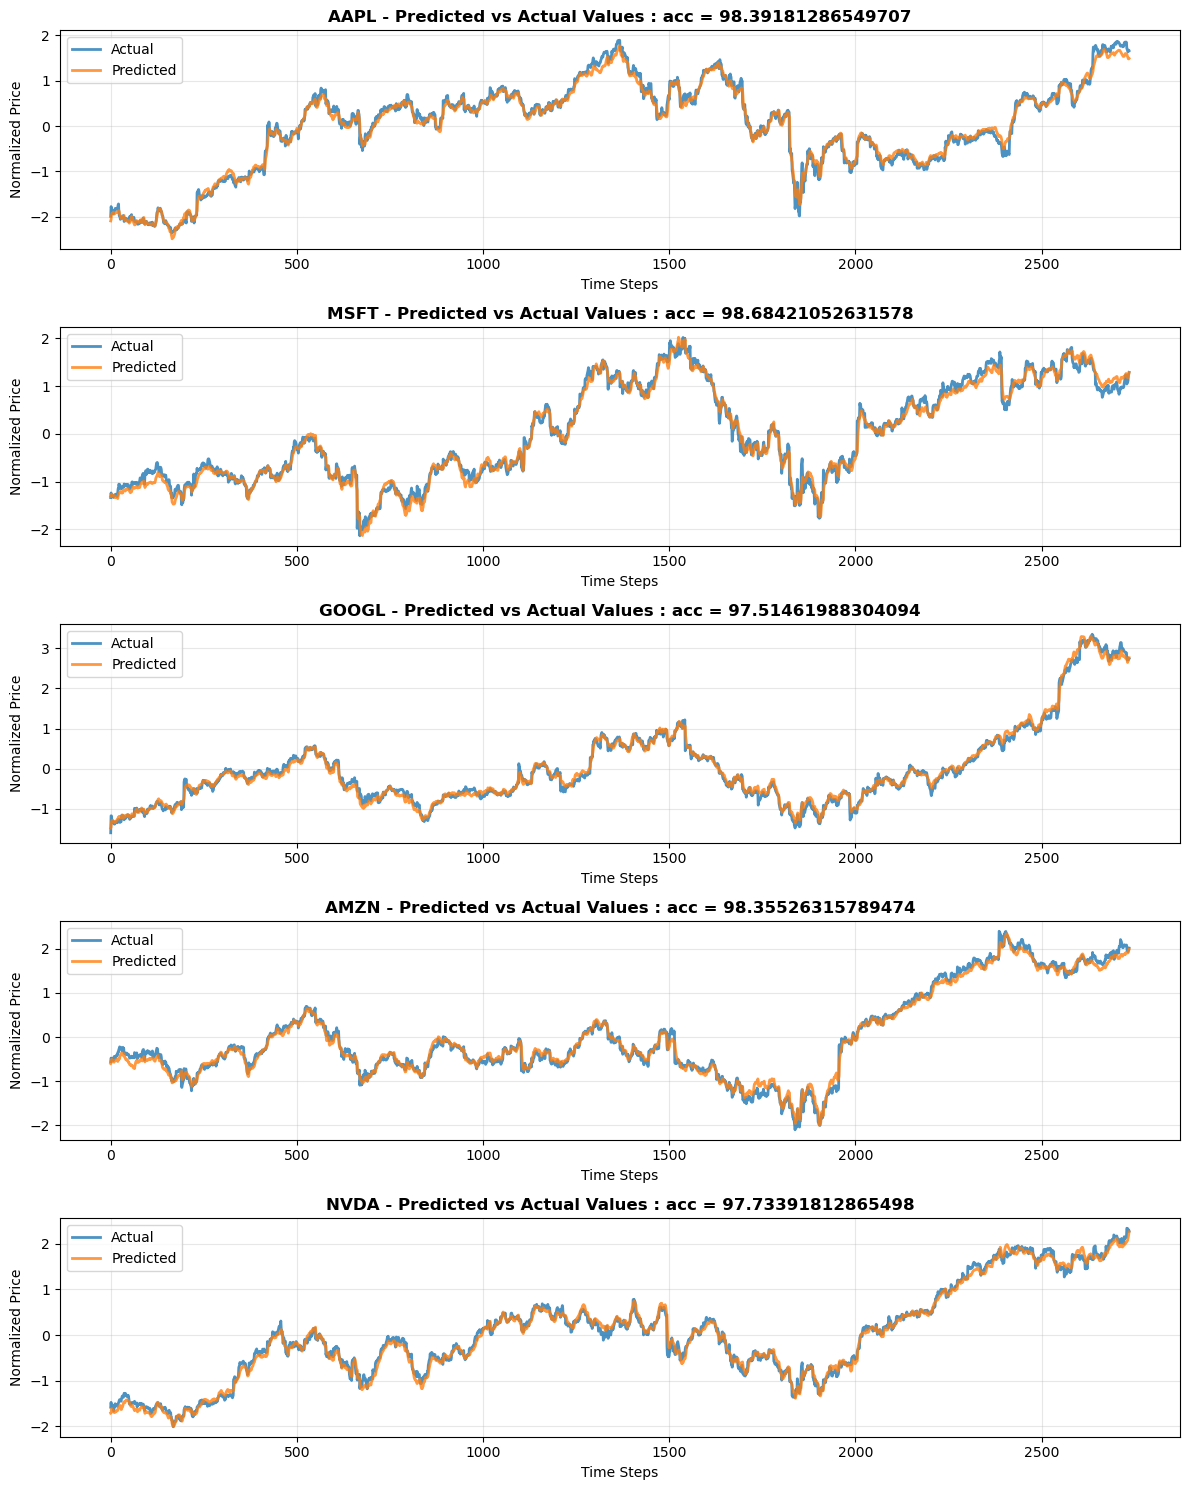

In [313]:
plot_predictions_by_asset(preds, Y, sample_tickers)

Testing And Validation

[*********************100%***********************]  5 of 5 completed
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A v

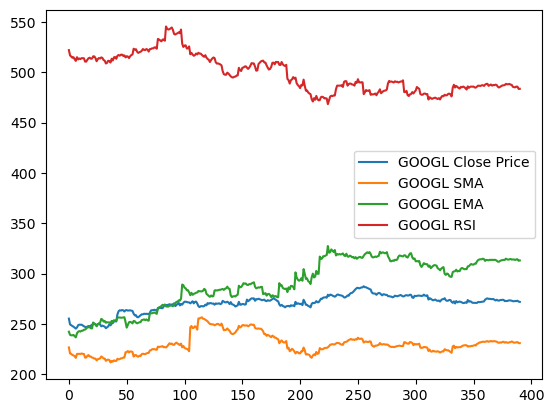

In [314]:
data = yf.download(sample_tickers, start=training_end, end=testing_end, interval = interval)
close = data['Close']

indicator_class = AddTechnicalIndicators(close, sample_tickers)
data = indicator_class.add_sma()
data = indicator_class.add_ema()
data = indicator_class.add_rsi()

data_frame = data 
data = data.to_numpy()

googl = data[:, 0]
googl_sma = data[:, 1]
googl_ema = data[:, 2]
googl_rsi = data[:, 3]

plt.plot(googl, label='GOOGL Close Price')
plt.plot(googl_sma, label='GOOGL SMA')
plt.plot(googl_ema, label='GOOGL EMA')
plt.plot(googl_rsi, label='GOOGL RSI')
plt.legend()
plt.show()

In [315]:

# norm_class = RollingZScoreNorm(data_frame)
# norm_data = norm_class.get_rolling_z(window=lookback)
data_frame = data_frame.to_numpy()[59:]


# norm_data = min_max_scaling.transform(data_frame)

norm_data = min_max_scaling.transform(data_frame)

test_x, test_y = add_look_back(norm_data, look_back=lookback)

# test_y = test_y[:, 0].reshape(test_y.shape[0], 1)

print(test_y.shape, test_x.shape)
test_y = test_y[:, :5]

(322, 20) (322, 10, 20)


In [316]:
test_pred = model.predict(test_x)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [317]:
print(test_pred.shape)

(322, 5)


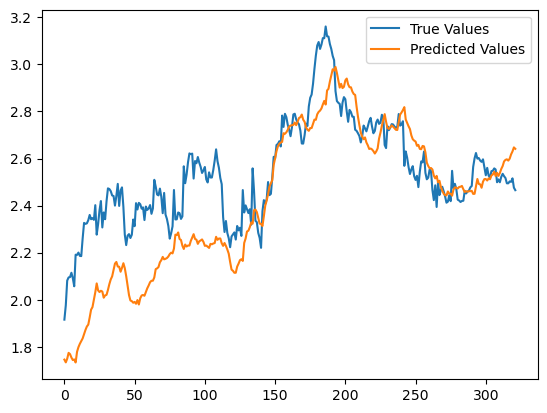

In [318]:
plt.plot(test_y[:, 0], label='True Values')
plt.plot(test_pred[:, 0], label='Predicted Values')
plt.legend()

In [319]:
# test_pred = test_pred.reshape(test_y.shape)
print(directional_accuracy(test_pred, test_y))
print(mae(test_pred, test_y))

100.0
0.32943002719057957


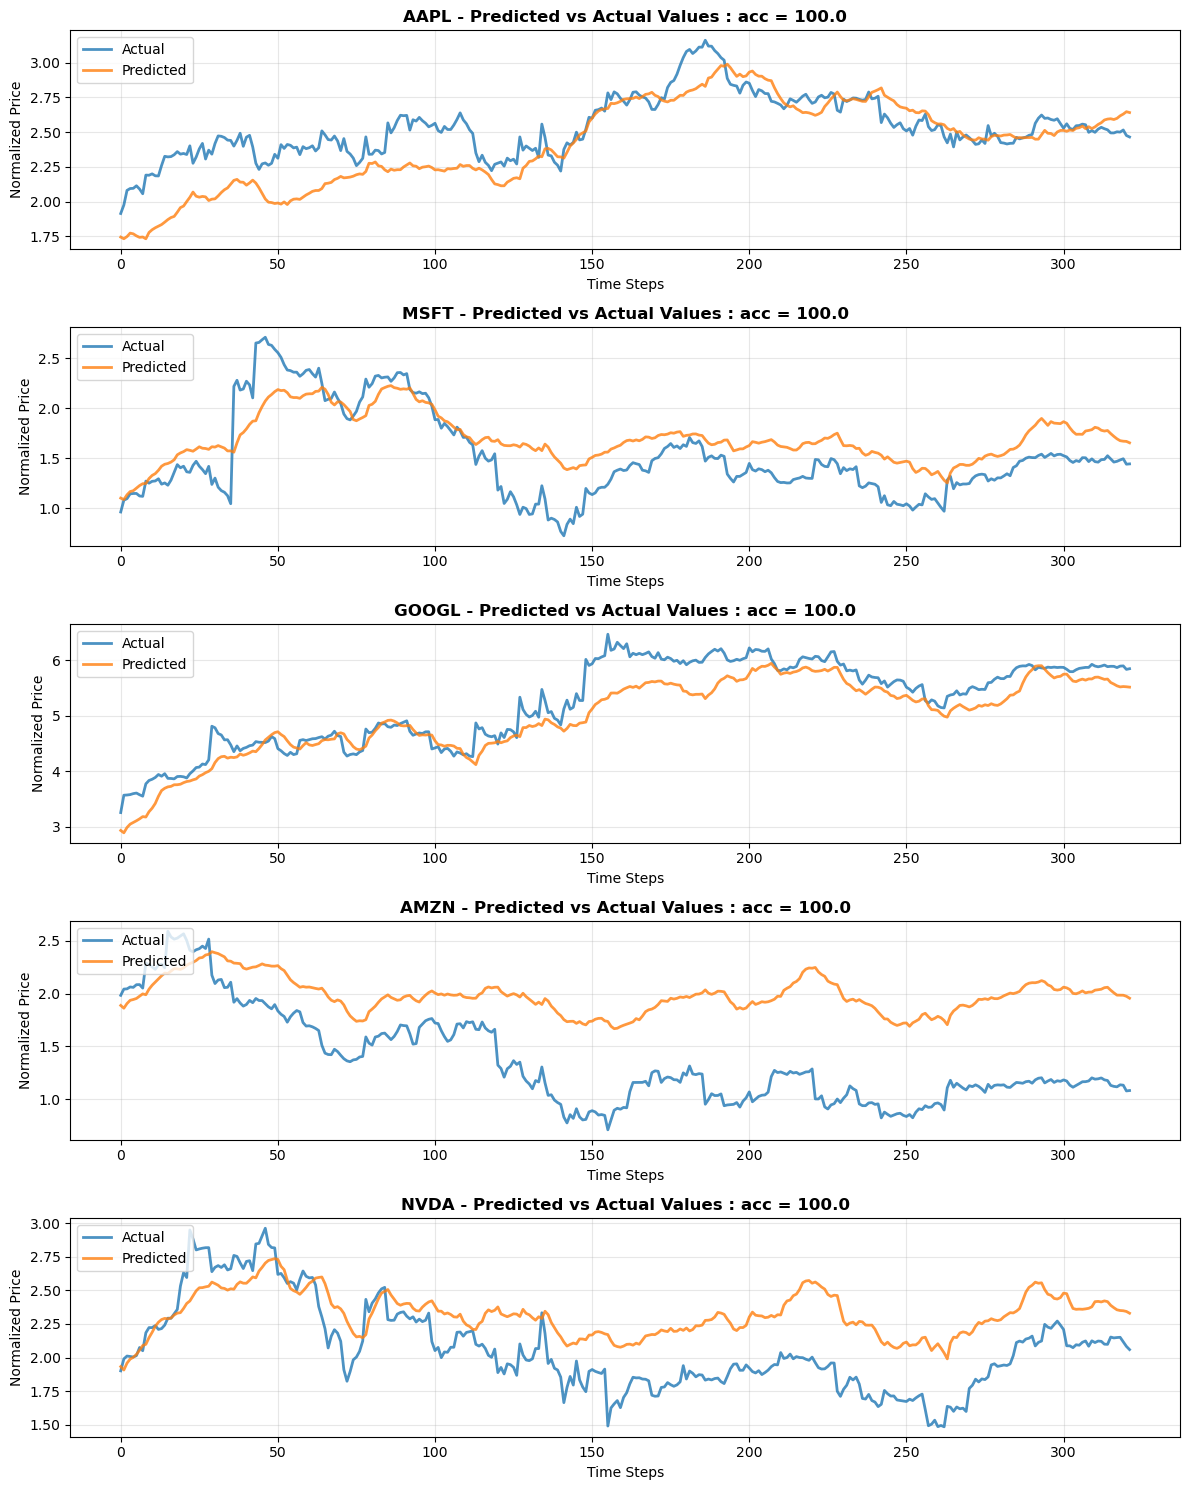

In [320]:


plot_predictions_by_asset(test_pred, test_y, sample_tickers)

In [321]:
print(test_pred.shape, test_y.shape)

(322, 5) (322, 5)


In [322]:
denorm_pred = min_max_scaling.inverse(test_pred)[:,0]
denorm_y = min_max_scaling.inverse(test_y)[:,0]
plt.plot(denorm_pred, label = 'pred')
plt.plot(denorm_y, label = 'true')
plt.legend()
plt.plot()

print(mae(denorm_pred, denorm_y))
print(directional_accuracy(denorm_pred, denorm_y))

AttributeError: 'StandardScaler' object has no attribute 'inverse'

In [ ]:
# Use the existing inverse_transform method from RollingZScoreNorm class
denormalized_test_pred = norm_class.inverse_transform(test_pred, window=lookback)
denormalized_test_y = norm_class.inverse_transform(test_y, window=lookback)

print("Denormalized predictions shape:", denormalized_test_pred.shape)
print("Denormalized actuals shape:", denormalized_test_y.shape)
print("\nFirst 5 denormalized predictions:")
print(denormalized_test_pred[:5])




NameError: name 'norm_class' is not defined

In [ ]:
plot_predictions_by_asset(denormalized_test_pred, denormalized_test_y, sample_tickers)